In [88]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
# matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.
plt.style.use('seaborn')
sns.set(font_scale = 2.5)

In [90]:
# pip install plotly

In [91]:
import plotly.offline as py
py.init_notebook_mode(connected = True)

In [92]:
import plotly.graph_objs as go
import plotly.tools as tls

In [93]:
import warnings
warnings.filterwarnings('ignore')

In [94]:
%matplotlib inline

In [95]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [96]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1  # 자신 포함해야해서 1 더함
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1  # 자신 포함해야해서 1 더함

In [97]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1


In [98]:
test.loc[test.Fare.isnull(),'Fare'] = test['Fare'].mean()

In [99]:
train['Fare'] = train['Fare'].map(lambda i : np.log(i) if i > 0 else 0)
test['Fare'] = test['Fare'].map(lambda i : np.log(i) if i > 0 else 0)

# 3. Feature engineering

In [100]:
# null data 를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지 될 수 있기 때문에, 신경써줘야할 부분입니다.
# Feature engineering 은 실제 모델의 학습에 쓰려고 하는 것이므로, train 뿐만 아니라 test 도 똑같이 적용해주어야 합니다.

## 3.1 Fill Null

### 3.1.1 Fill Null in Age using title

In [101]:
# Miss, Mrr, Mrs 같은 title 추출
train['Initial'] = train['Name'].str.extract('([A-Za-z]+)\.')
test['Initial'] = test['Name'].str.extract('([A-Za-z]+)\.')

In [102]:
# Initial 과 Sex 간의 count 를 살펴봅시다.
pd.crosstab(train['Initial'], train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [103]:
train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                         ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [104]:
train.groupby('Initial').mean()
# => Master / Miss / Mrs 가 생존률이 높음

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


In [105]:
train.groupby('Initial')['Survived'].mean()

Initial
Master    0.575000
Miss      0.704301
Mr        0.162571
Mrs       0.795276
Other     0.111111
Name: Survived, dtype: float64

<AxesSubplot:xlabel='Initial'>

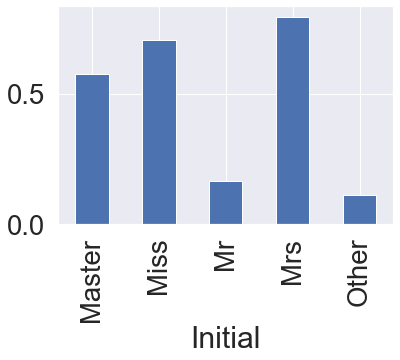

In [106]:
train.groupby('Initial')['Survived'].mean().plot.bar()

In [107]:
# # Null 값 채우는 방법 : 
# (1) statistics 를 활용하는 방법
# (2) null data 가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식

In [108]:
# 여기서 statistics 는 train data에서 얻은 값을 의미합니다.
# 언제나 test는 unseen으로 둔 상태로 놔둬야 하며, train에서 얻은 statistics를 기반으로 test의 null data를 채워줘야 합니다.

In [109]:
train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


In [110]:
# 대충 null값 채우기
train.loc[(train.Age.isnull())&(train.Initial=='Mr'),'Age'] = 33
train.loc[(train.Age.isnull())&(train.Initial=='Mrs'),'Age'] = 36
train.loc[(train.Age.isnull())&(train.Initial=='Master'),'Age'] = 5
train.loc[(train.Age.isnull())&(train.Initial=='Miss'),'Age'] = 22
train.loc[(train.Age.isnull())&(train.Initial=='Other'),'Age'] = 46

test.loc[(test.Age.isnull())&(test.Initial=='Mr'),'Age'] = 33
test.loc[(test.Age.isnull())&(test.Initial=='Mrs'),'Age'] = 36
test.loc[(test.Age.isnull())&(test.Initial=='Master'),'Age'] = 5
test.loc[(test.Age.isnull())&(test.Initial=='Miss'),'Age'] = 22
test.loc[(test.Age.isnull())&(test.Initial=='Other'),'Age'] = 46

### 3.1.2 Fill Null in Embarked

In [111]:
print('Embarked has',sum(train['Embarked'].isnull()), 'Null values')

Embarked has 2 Null values


In [112]:
# Embarked 는 Null value 가 2개이고, S 에서 가장 많은 탑승객이 있었으므로, 간단하게 Null 을 S로 채우겠습니다.
train['Embarked'].fillna('S', inplace=True)

## 3.2 Change Age(continuous to categorical)

In [113]:
# Age는 현재 continuous feature 입니다. 이대로 써도 모델을 세울 수 있지만, Age를 몇개의 group으로 나누어 category화 시켜줄 수도 있습니다. continuous를 categorical로 바꾸면 자칫 information loss가 생길 수도 있습니다만, 본 튜토리얼에서는 다양한 방법을 소개하는 것이 목적이므로 진행하도록 하겠습니다.

In [114]:
## 귀찮은 방법
# 10살 간격으로 나눔
train['Age_cat'] = 0
train.loc[train['Age'] < 10, 'Age_cat'] = 0
train.loc[(10 <= train['Age']) & (train['Age'] < 20), 'Age_cat'] = 1
train.loc[(20 <= train['Age']) & (train['Age'] < 30), 'Age_cat'] = 2
train.loc[(30 <= train['Age']) & (train['Age'] < 40), 'Age_cat'] = 3
train.loc[(40 <= train['Age']) & (train['Age'] < 50), 'Age_cat'] = 4
train.loc[(50 <= train['Age']) & (train['Age'] < 60), 'Age_cat'] = 5
train.loc[(60 <= train['Age']) & (train['Age'] < 70), 'Age_cat'] = 6
train.loc[70 <= train['Age'], 'Age_cat'] = 7

test['Age_cat'] = 0
test.loc[test['Age'] < 10, 'Age_cat'] = 0
test.loc[(10 <= test['Age']) & (test['Age'] < 20), 'Age_cat'] = 1
test.loc[(20 <= test['Age']) & (test['Age'] < 30), 'Age_cat'] = 2
test.loc[(30 <= test['Age']) & (test['Age'] < 40), 'Age_cat'] = 3
test.loc[(40 <= test['Age']) & (test['Age'] < 50), 'Age_cat'] = 4
test.loc[(50 <= test['Age']) & (test['Age'] < 60), 'Age_cat'] = 5
test.loc[(60 <= test['Age']) & (test['Age'] < 70), 'Age_cat'] = 6
test.loc[70 <= test['Age'], 'Age_cat'] = 7

In [115]:
# 함수 만들어서 apply 메소드에 넣어줌
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7    
    
train['Age_cat_2'] = train['Age'].apply(category_age)

In [116]:
# 두가지 방법이 잘 적용됬다면, 둘다 같은 결과를 내야합니다.
# 이를 확인하기 위해 Series 간 boolean 비교 후 all() 메소드를 사용합시다. all() 메소드는 모든 값이 True 면 True, 하나라도 False 가 있으면 False 를 줍니다.

In [117]:
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 -> ', (train['Age_cat'] == train['Age_cat_2']).all())

1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 ->  True


In [118]:
# => 둘 중 편한 걸 선택하시면 됩니다.
#    중복되는 Age_cat 컬럼과 원래 컬럼 Age 를 제거

In [119]:
train.drop(['Age','Age_cat_2'], axis = 1, inplace=True)
test.drop(['Age'], axis = 1, inplace=True)

## 3.3 Change Initial, Embarked and Sex (string to numerical)

In [120]:
# 현재 Initial 은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있습니다. 이런 카테고리로 표현되어져 있는 데이터를 모델에 인풋으로 넣어줄 때 우리가 해야할 것은 먼저 컴퓨터가 인식할 수 있도록 수치화 시켜야 합니다.
# map method 를 가지고 간단히 할 수 있습니다.
# 사전 순서대로 정리하여 mapping 하겠습니다

In [121]:
train['Initial'] = train['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})
test['Initial'] = test['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})

In [122]:
# Embarked 도 C, Q, S로 이루어져 있습니다. map 을 이용해 바꿔봅시다.
# 그러기 앞서서, 특정 column 에 어떤 값들이 있는 지 확인해보는 방법을 잠깐 살펴보겠습니다. 간단히 unique() 메소드를 쓰거나, value_counts() 를 써서 count 까지 보는 방법이 있습니다.

In [123]:
train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [124]:
train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [125]:
train['Embarked'] = train['Embarked'].map({'C':0,'Q':1,'S':2})
test['Embarked'] = test['Embarked'].map({'C':0,'Q':1,'S':2})

In [126]:
train['Embarked'].isnull().any()

False

In [128]:
# any() 를 사용하여, True 가 단하나라도 있을 시(Null이 한개라도 있을 시) True 를 반환해주게 됩니다. 우리는 Null 을 S로 다 바꿔주었으므로 False 를 얻게 됩니다

In [130]:
train['Sex'] = train['Sex'].map({'female':0,'male':1})
test['Sex'] = test['Sex'].map({'female':0,'male':1})

In [ ]:
# 이제 각 feature 간의 상관관계를 한번 보려고 합니다.
# 우리는 여러 feature 를 가지고 있으니 이를 하나의 maxtrix 형태로 보면 편할 텐데, 이를 heatmap plot 이라고 하며, dataframe 의 corr() 메소드와 seaborn 을 가지고 편하게 그릴 수 있습니다.

In [133]:
heatmap_data = train[['Survived','Pclass','Sex','Fare','Embarked','FamilySize','Initial','Age_cat']]
heatmap_data.head(3)

,Survived,Pclass,Sex,Fare,Embarked,FamilySize,Initial,Age_cat
0,0,3,1,1.981001,2,2,2,2
1,1,1,0,4.266662,0,2,3,3
2,1,3,0,2.070022,2,1,1,2


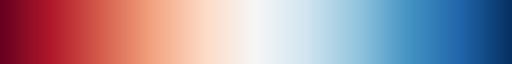

In [135]:
colormap = plt.cm.RdBu
colormap

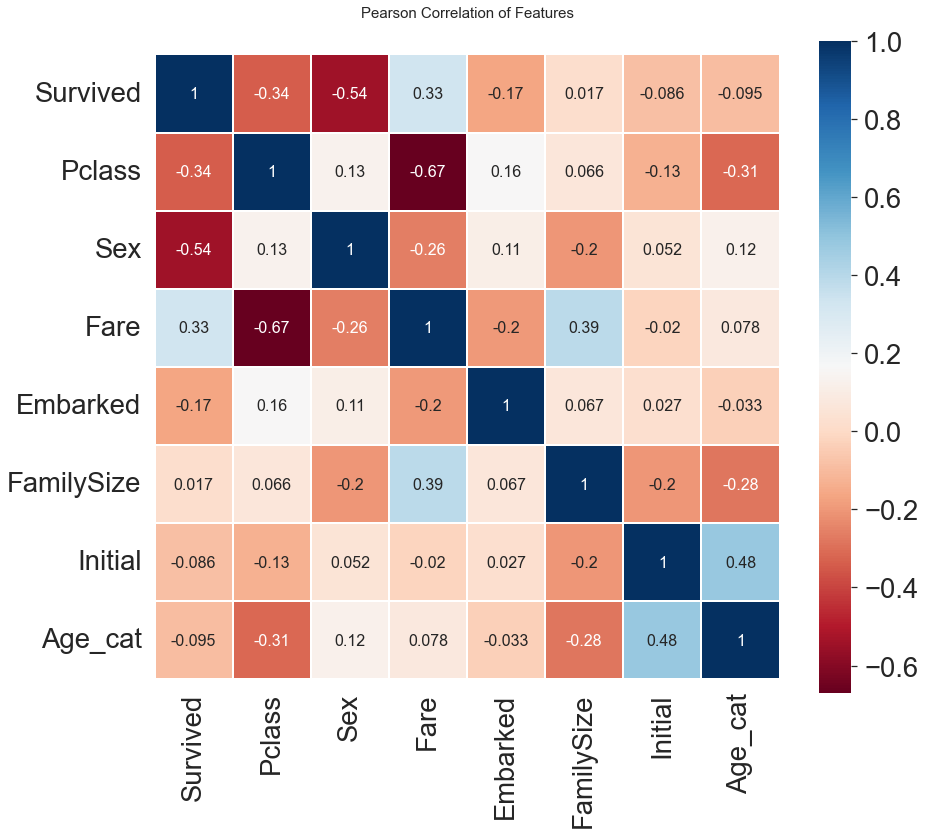

In [153]:
plt.figure(figsize = (14,12))
plt.title('Pearson Correlation of Features', y = 1.05, size = 15)

# annot=True : 상관계수 값 표시
# annot_kws={'size':16} : 상관계수 값 글자 크기 키우기
sns.heatmap(heatmap_data.astype(float).corr(), linewidths = 0.1, vmax = 1.0, square = True, cmap = colormap, linecolor = 'white', annot=True, annot_kws={'size':16})
del heatmap_data

In [ ]:
# 우리가 EDA에서 살펴봤듯이, Sex 와 Pclass 가 Survived 에 상관관계가 어느 정도 있음을 볼 수 있습니다.
# 생각보다 fare 와 Embarked 도 상관관계가 있음을 볼 수 있습니다.
# 또한 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 가지는 feature들이 없다는 것입니다.
# 이것은 우리가 모델을 학습시킬 때, 불필요한(redundant, superfluous) feature 가 없다는 것을 의미합니다. 1 또는 -1 의 상관관계를 가진 feature A, B 가 있다면, 우리가 얻을 수 있는 정보는 사실 하나일 거니까요.
# 이제 실제로 모델을 학습시키기 앞서서 data preprocessing (전처리)을 진행해보겠습니다.

## 3.4 One-hot encoding on Initial and Embarked